# Graph exploration & analysis

--------------

** Considering how huge the overall dataset is, we must try to define a way in order to extract a subgraph from the overall graph which part only concerns the infected. For short, we try to extract a subragraph of the concerned "population" for a given hashtag.**

**This notebook shows the differents methods we tried to identify.**

## Preliminaries

- ### Objective :

Predict the virality of memes/hashtags in a social network (Twitter).

- ### Context and motivations :

Virality is, in social networks, an important issue for corporations, political campaigns and influencers as they spend enormous resources and efforts to make their products or messages go viral in order to catch attention and spread their influence/activities to a wider audience.
Thus, understanding the complex mechanism of virality may help one control its effects over the network:
- How does the network structure affect the diffusion? 
- How to model the contagion, etc.

Proposal brought by the paper : the  broad idea is that network communities allow predict virality by its early spreading pattern. A simple, popular approach in studying hashtags diffusion is to consider hashtags as diseases and apply epidemic models. However, recent studies demonstrate that diseases and behaviors spread differently.
We can see huge potentiality for applications in social media marketing : social networks could give better advice to their users as to which posts are likely to give best advertising Return on Investment.


- ### Imports

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import product
from itertools import permutations, combinations
import datetime
%matplotlib inline

## I. Data exploration

**** CITATION ****
Please cite our paper as follows, when you are using our dataset:
Lilian Weng, Filippo Menczer, and Yong-Yeol Ahn. Virality Prediction and Community Structure in Social Networks. Nature Scientific Report. (3)2522, 2013.



**** DATA SOURCE ****
Sampled public tweets from Twitter streaming API (https://dev.twitter.com/docs/streaming-apis).
Date range: March 24, 2012 to April 25, 2012.



**** NETWORKS ****
follower_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID
    Anonymized reciprocal follower network.
    Each edge is a pair of Twitter user who are following each other. After recovering the reciprocal follower network, the giant connected component is extracted.

retweet_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who retweeted each other at least once during our observation time window. Weight is the sum of how many times user1 retweeted user2 or user2 retweeted user1.

mention_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who mentioned each other at least once during our observation time window. Weight is the sum of how many times user1 mentioned user2 or user2 mentioned user1.



**** HASHTAG SEQUENCES ****
timeline_tag.anony.dat
    Format: hashtag timestamp1,anony.user1.id timestamp2,anony.user2.id ...
    Each line is a hashtag followed by the sequence of its adopters sorted by timestamp. A user is considered as an adopter of a hashtag once he/she starts using the hashtag. We only consider users who appear in the collected networks. The timestamp is the time when we see the hashtag in the user's tweets. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_rt.anony.dat
    Format: hashtag timestamp1,anony.retweet_user1.id,anony.retweet_from_user1.id timestamp2,anony.retweet_user2.id,anony.tweet_from_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters retweeting about this hashtag from other users sorted by timestamp. A "retweet_user" retweets a message containing the hashtag from a "retweet_from_user". We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_men.anony.dat
    Format: hashtag timestamp1,anony.mention_user1.id,anony.mentioned_user1.id timestamp2,anony.mention_user2.id,anony.mentioned_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters mentioning other users in messages containing this hashtags sorted by timestamp. A "mention_user" mentions a "mentioned_user" in a message with the target hashtag. We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.



** Note that users in these networks and timeline sequencies are anonymized in the same way so that the same IDs refer to the same Twitter users.**

In [2]:
#load from raw dat file into dataframes
    #for relationships graphs
df1 = pd.read_csv('../../../virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
#df2 = pd.read_csv('../../../virality2013/mention_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
#df3 = pd.read_csv('../../../virality2013/retweet_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
    
    #for hashtags spreading, the data format is too large to compute as matrix (over billion units)
#df4 = pd.read_csv('../../../virality2013/timeline_tag.anony.dat',sep=' ',header=None,names=header_tl)
#df5 = pd.read_csv('../../../virality2013/timeline_tag_men.anony.dat',sep=' ',header=None,names=header_tl_men)
#df6 = pd.read_csv('../../../virality2013/timeline_tag_rt.anony.dat',sep=' ',header=None,names=header_tl_rt)

- ### Hashtags analysis

In [3]:
ht=[]
l=[]
n=0
with open('../../../virality2013/timeline_tag.anony.dat',"r") as f:
    for line in f:
        hashtag = line.split(" ")[0]
        size = len(line.split(" "))
        ht.append(hashtag)
        l.append(size)
ht_df=pd.DataFrame()
ht_df['hashtag']=ht
ht_df['count_adopters']=l

print("Max len for a row : %s" %max(l))
print("Nb of hashtags : %s" %(len(ht)))

Max len for a row : 363519
Nb of hashtags : 1345913


In [4]:
ht_df = ht_df[ht_df['hashtag'].str.len() > 3] #filter meaningless hashtags
ht_df.sort(columns='count_adopters',ascending=False,inplace=True)
ht_df.reset_index(inplace=True,drop=True)

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


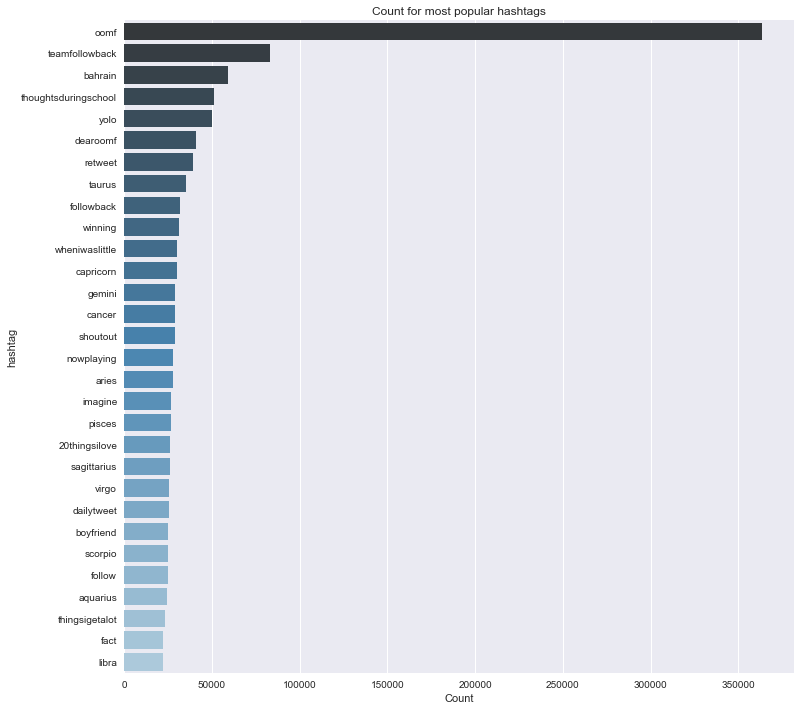

In [5]:
ht_df_ = ht_df[0:30]
plt.figure(figsize=(12,12))
a=sns.barplot(y=ht_df_['hashtag'],x=ht_df_['count_adopters'],palette="Blues_d")
a.set_title('Count for most popular hashtags')
a.set_xlabel('Count')

- ### Light Network Analysis:

In [6]:
%%time
g1 = nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
g1 = g1.to_undirected()

CPU times: user 4min 19s, sys: 11 s, total: 4min 30s
Wall time: 4min 28s


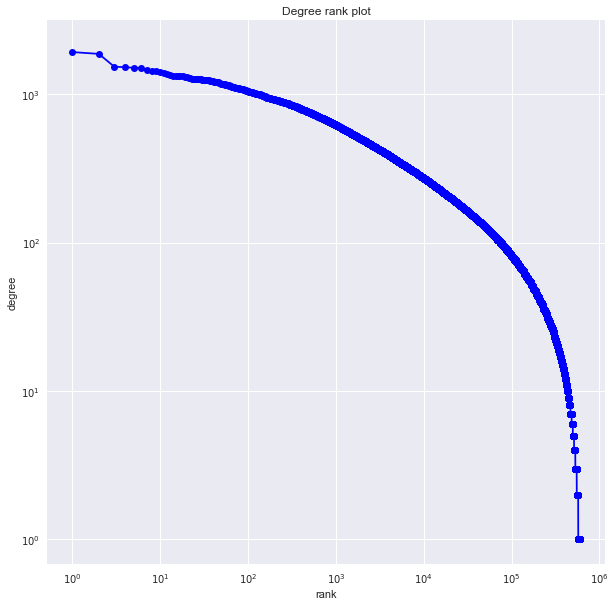

CPU times: user 8.69 s, sys: 238 ms, total: 8.93 s
Wall time: 8.93 s


In [7]:
%%time
degree_sequence=sorted(nx.degree(g1).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

In [ ]:
print('The complete graph contains: \n - %s nodes\n - %s edges.' %(len(g1.nodes()),len(g1.edges())))

## II. Sampling

- ### Random node sampling: 

In [8]:
def sample_nodes(node_list,ratio):
    nb_sample = ratio*len(node_list)
    nb_sample = int(nb_sample)
    sample = np.random.choice(np.array(node_list),size=nb_sample)
    return sample

def get_nodes(g):
    node_list = list(g.nodes())
    return node_list

def induced_graphed(vertex,g):
    return 

In [9]:
%%time
nodes1 = get_nodes(g1)
sample = sample_nodes(nodes1,0.01)

CPU times: user 56.8 ms, sys: 2.85 ms, total: 59.7 ms
Wall time: 61.7 ms


- ### Degree distribution sampling

## III. Hashtags community:

- ### Simple functions (toolbox)

In [10]:
def extract_from_hash(hashtag,file_path,extended=True):
    mat = []    
    if extended == True:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag in line:
                    mat.append(line.split(" "))
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)
    else:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag == line.split(" ")[0]:
                    mat.append(line.split(" "))
                    break
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)

def pad(list_,length):
    return list_[:length] + [np.nan]*(length-len(list_))

def find_infected_vertex(df):
    keep=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        keep.append([x[1] for x in array if isinstance(x,list)])
    return list(set([val for sublist in keep for val in sublist]))

def find_infected_timeline(df):
    #return a dataframe with two columns, infected ids and timeline, by ascending order
    timeline=[]
    ids=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        timeline.append([x[0] for x in array if isinstance(x,list)])
        ids.append([x[1] for x in array if isinstance(x,list)])
    timeline=[val for sublist in timeline for val in sublist]
    ids=[val for sublist in ids for val in sublist]
    if len(ids)!=len(timeline):
        print('Warning, timelines and ids do not match completly!')
    inf_df = pd.DataFrame()
    inf_df['infected_id']=ids
    inf_df['timeline']=timeline
    return inf_df

def split_clean(list_):
    array= [ x.split(",") for x in list_]
    array= [ np.nan if x[0]=='nan' else [int(x[0]),int(x[1].strip('\n'))] for x in array ]
    return array

def query_from_vertices(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    return df


def convert_timestamp(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)#.strftime('%Y-%m-%d %H:%M:%S')

#automate function:
def compute_timeline_sum(df,hashtag):
    data = find_infected_timeline(df)
    data=data.sort_values('timeline', ascending=True)
    data['timeline'] = data.timeline.apply(lambda x : convert_timestamp(x))

    #indicators
    cumulated=range(0,len(data))
    data[hashtag]=cumulated
    data.set_index('timeline',inplace=True)
    return data, data.index

def compute_timeline_intensity(df,hashtag):
    data = find_infected_timeline(df)
    data=data.sort_values('timeline', ascending=True)
    data['timeline'] = data.timeline.apply(lambda x : convert_timestamp(x))

    #indicators
    data.set_index('timeline',inplace=True)
    #data.columns= [hashtag]
    data[hashtag]=[1]*len(data)
    return data, data.index

def compute_shortest(couple):
    if couple[0] not in master_nodes or couple[1] not in master_nodes:
        return None
    else:
        try:
            nodes=nx.shortest_path(g1,source=couple[0],target=couple[1])
        except Exception as e:
            print('Failed at stage %s %s for reason : %s' %(couple[0],couple[1],e))
            nodes=None
        return nodes
    
def compute_shortest_speed(couple):
    #without if control, loop is 10x faster
    try:
        nodes=nx.shortest_path(g1,source=couple[0],target=couple[1])
    except Exception as e:
        #print('Failed at stage %s %s for reason : %s' %(couple[0],couple[1],e))
        nodes=None
    return nodes

In [11]:
%%time
#guncontrol teamunicorns genocide  ThoughtsDuringSchool madonna
hashtag='madonna'
df = extract_from_hash(hashtag,"../../../virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)
t_timeline = find_infected_timeline(df)
print("There are %s infected nodes for the hashtags %s" %(len(t),hashtag))

There are 159 infected nodes for the hashtags madonna
CPU times: user 524 ms, sys: 34.5 ms, total: 559 ms
Wall time: 559 ms


- #### Method 1 : Only extract neighbours of infected users

In [12]:
%%time
#add old
df1 = pd.read_csv('../../../virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
df1=query_from_vertices(df1,t)

h_=nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
h_ = h_.to_undirected()


CPU times: user 7.07 s, sys: 537 ms, total: 7.61 s
Wall time: 7.61 s


/usr/local/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprec

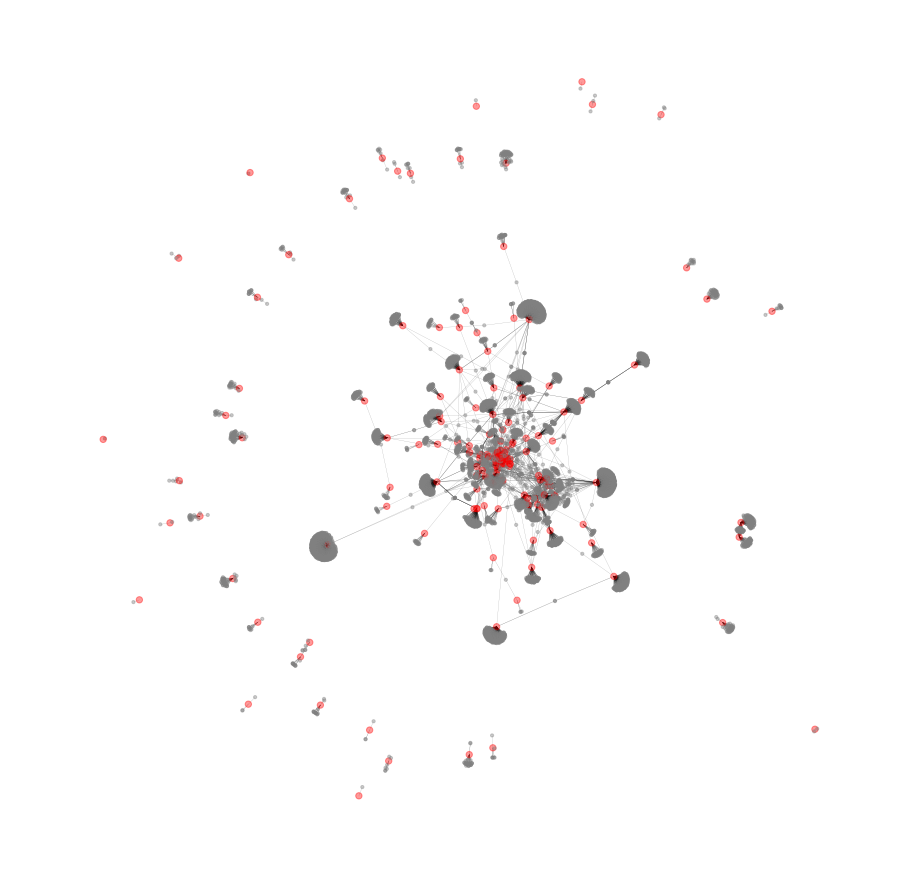

CPU times: user 1min 44s, sys: 170 ms, total: 1min 44s
Wall time: 1min 44s


In [13]:
%%time
#plot subgraph
color_map=[]
size = []
for node in h_:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h_, **options_3)
plt.savefig("%s_graped_graph.png" %(hashtag), dpi=300)
plt.show()

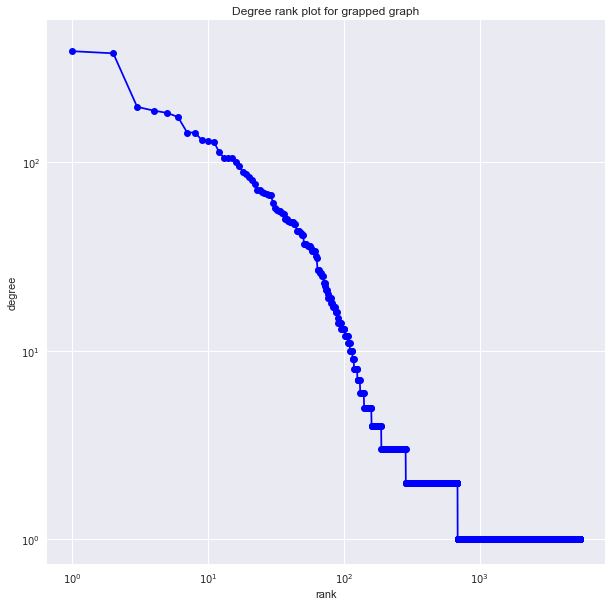

In [14]:
#Plot degree distribution for method 1
degree_sequence=sorted(nx.degree(h_).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot for grapped graph")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

- #### Method 2 : Extract subgraph formed by shortest path between the combination of all infected users

In [15]:
%%time
#combination multiprocessed
#multiprocessing alternatives for shortest path
import multiprocessing as mp
import datetime


master_nodes=g1.nodes()
combi = list(combinations(t,2))
print(len(combi))

try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    nodes_ = pool.map(compute_shortest_speed,combi)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')


#purge
del combi
del master_nodes

12561
Done processing in 0:00:02.419683
CPU times: user 75.7 ms, sys: 178 ms, total: 254 ms
Wall time: 2.62 s


In [16]:
#filter none
nodes_ = [x  for x in nodes_ if x]

In [17]:
%%time
flat=[val for sublist in nodes_ for val in sublist]
print(len(flat))

56689
CPU times: user 6.36 ms, sys: 2.32 ms, total: 8.68 ms
Wall time: 7.24 ms


In [18]:
#flat = sample_nodes(flat,1)
h=g1.subgraph(flat)
len(h.nodes())

5530

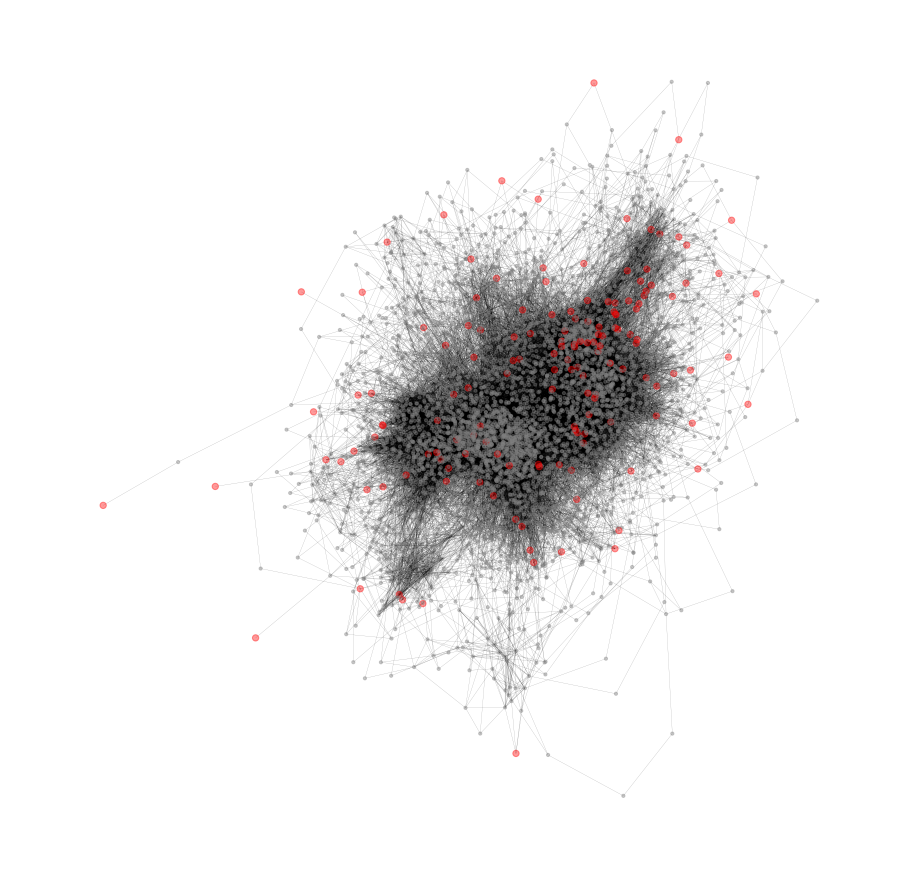

CPU times: user 1min 53s, sys: 351 ms, total: 1min 53s
Wall time: 1min 53s


In [19]:
%%time
#plot subgraph for method 2
color_map=[]
size = []
for node in h:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("%s_shortest_path.png" %(hashtag), dpi=300)
plt.show()

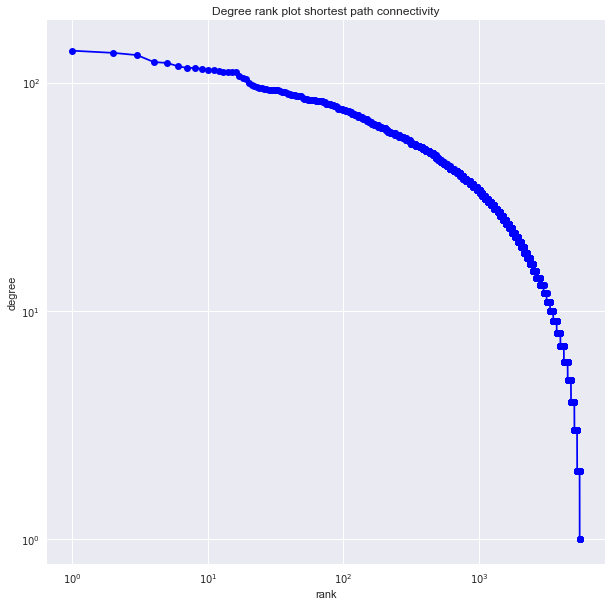

In [20]:
#Plot degree distribution for methods 2
degree_sequence=sorted(nx.degree(h).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot shortest path connectivity")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

- ### Method 1 + Method 2 = composing both previous method

In [21]:
#compose
composed = nx.compose(h,h_)

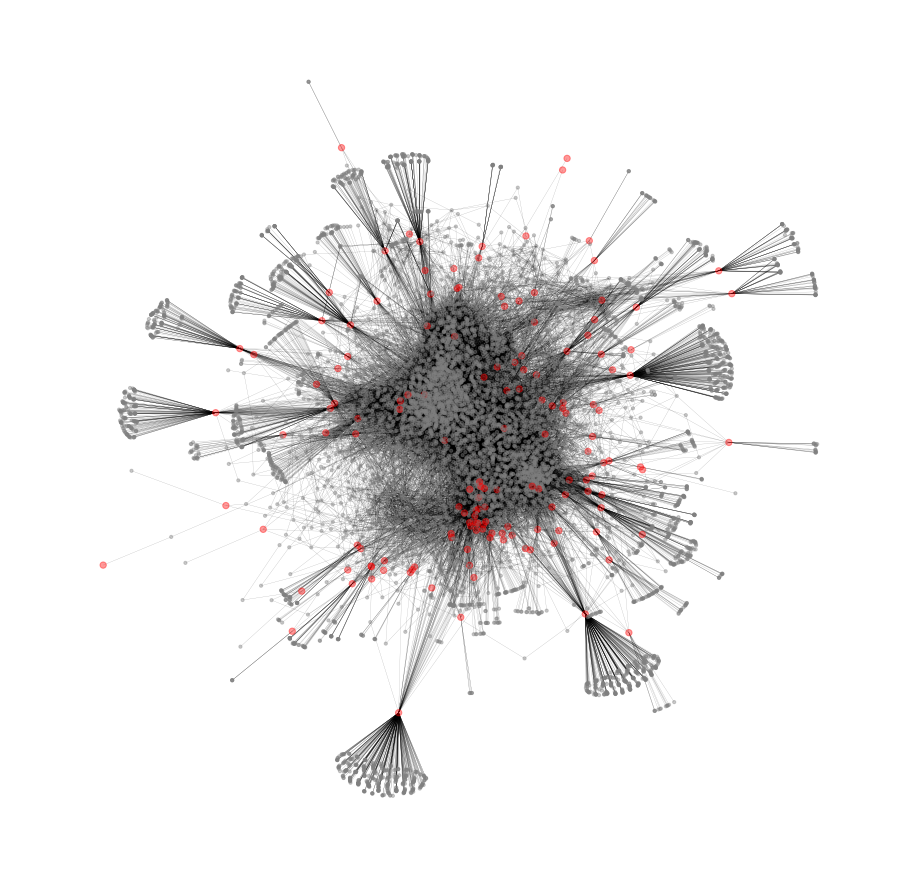

CPU times: user 4min, sys: 477 ms, total: 4min
Wall time: 4min


In [22]:
%%time

color_map=[]
size = []
for node in composed:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(composed, **options_3)
plt.savefig("output_pictures/%s_composed.png" %(hashtag), dpi=300)
plt.show()

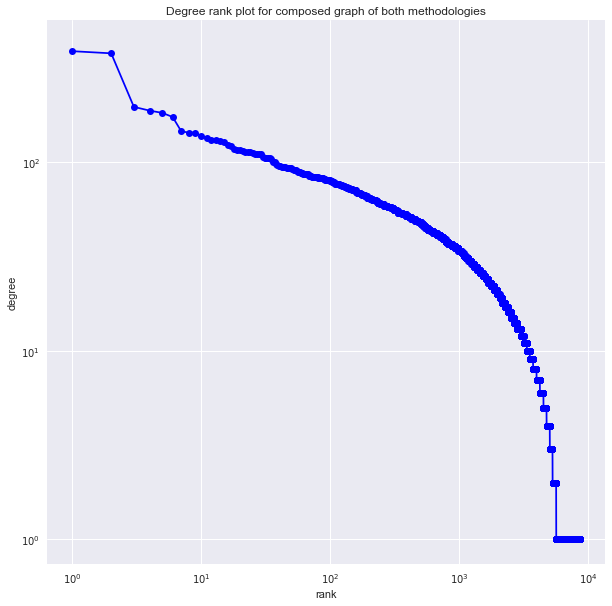

In [23]:
degree_sequence=sorted(nx.degree(composed).values(),reverse=True) # degree sequence

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot for composed graph of both methodologies")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

## IV. Differents communitys for different hashtags:

- #### foxnews + bbc

In [24]:
df = extract_from_hash('foxnews',"../../../virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)
df = extract_from_hash('news',"../../../virality2013/timeline_tag.anony.dat",extended = False)
t2=find_infected_vertex(df)

In [25]:
%%time
#foxnews
import multiprocessing as mp
import datetime


master_nodes=g1.nodes()
combi = list(combinations(t,2))
print(len(combi))

try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    nodes_ = pool.map(compute_shortest_speed,combi)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')


#purge
del combi
del master_nodes

26106
Done processing in 0:00:01.882741
CPU times: user 102 ms, sys: 183 ms, total: 285 ms
Wall time: 2.06 s


In [26]:
nodes_ = [x  for x in nodes_ if x]
foxnews_nodes=[val for sublist in nodes_ for val in sublist]
foxnews=g1.subgraph(foxnews_nodes)
len(h.nodes())

5530

In [27]:
%%time
#news
import multiprocessing as mp
import datetime


master_nodes=g1.nodes()
combi = list(combinations(t2,2))
print(len(combi))

try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    nodes_ = pool.map(compute_shortest_speed,combi)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')


#purge
del combi
del master_nodes

723003
Done processing in 0:03:09.378652
CPU times: user 12.2 s, sys: 1.6 s, total: 13.8 s
Wall time: 3min 9s


In [28]:
nodes_ = [x  for x in nodes_ if x]
news_nodes=[val for sublist in nodes_ for val in sublist]
news=g1.subgraph(news_nodes)
len(h.nodes())

5530

In [ ]:
%%time
composed = nx.compose(foxnews,news)

CPU times: user 2.5 s, sys: 208 ms, total: 2.71 s
Wall time: 2.67 s


In [ ]:
%%time
color_map=[]
size = []
for node in composed:
    if node in t or node in t2:
        color_map.append('red')
        size.append(40)
    elif node in news:
        color_map.append('yellow')
        size.append(10)
    elif node in foxnews:
        color_map.append('blue')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(composed, **options_3)
plt.savefig("output_pictures/composedgraph_news-foxnews_shortes1.png", dpi=400)
plt.show()

- #### foxnews + madonna

In [ ]:
hashtag='madonna'
df = extract_from_hash(hashtag,"../../../virality2013/timeline_tag.anony.dat",extended = False)
t3=find_infected_vertex(df)

In [ ]:
%%time
#news
import multiprocessing as mp
import datetime


master_nodes=g1.nodes()
combi = list(combinations(t2,2))
print(len(combi))

try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    nodes_ = pool.map(compute_shortest_speed,combi)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')


#purge
del combi
del master_nodes

#flatten
nodes_ = [x  for x in nodes_ if x]
madonna_nodes=[val for sublist in nodes_ for val in sublist]
madonna=g1.subgraph(madonna_nodes)

%%time
composed = nx.compose(foxnews,madonna)

In [ ]:
%%time
color_map=[]
size = []
for node in composed:
    if node in t or node in t3:
        color_map.append('red')
        size.append(40)
    elif node in foxnews:
        color_map.append('yellow')
        size.append(10)
    elif node in madonna:
        color_map.append('blue')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(composed, **options_3)
plt.savefig("output_pictures/composedgraph_madonna-foxnews_shortes1.png", dpi=400)
plt.show()